In [24]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip 

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:03<00:00, 224MB/s]
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [26]:

train_dir = './train'
test_dir = './test1'

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [27]:
print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

Number of images in ./train is 25000
Number of images in ./test1 is 12500


In [28]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

./train/dog.5169.jpg


In [29]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

In [30]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0 

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [31]:
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

In [32]:
train.__getitem__(0)

(tensor([[[0.1333, 0.1412, 0.1451,  ..., 0.1294, 0.1216, 0.1137],
          [0.1451, 0.1490, 0.1569,  ..., 0.1373, 0.1294, 0.1216],
          [0.1529, 0.1647, 0.1647,  ..., 0.1412, 0.1333, 0.1294],
          ...,
          [0.5020, 0.5294, 0.5098,  ..., 0.5765, 0.5490, 0.5216],
          [0.4824, 0.6039, 0.6392,  ..., 0.5647, 0.5255, 0.5059],
          [0.5843, 0.6314, 0.6549,  ..., 0.5137, 0.5020, 0.4941]],
 
         [[0.3255, 0.3333, 0.3412,  ..., 0.3255, 0.3176, 0.3059],
          [0.3373, 0.3412, 0.3412,  ..., 0.3333, 0.3255, 0.3216],
          [0.3490, 0.3529, 0.3333,  ..., 0.3412, 0.3333, 0.3294],
          ...,
          [0.5255, 0.5647, 0.5412,  ..., 0.6196, 0.5843, 0.5608],
          [0.4902, 0.6431, 0.6824,  ..., 0.6078, 0.5725, 0.5529],
          [0.6235, 0.6706, 0.6902,  ..., 0.5608, 0.5529, 0.5373]],
 
         [[0.5569, 0.5647, 0.5804,  ..., 0.5725, 0.5647, 0.5529],
          [0.5686, 0.5686, 0.5725,  ..., 0.5804, 0.5725, 0.5647],
          [0.5922, 0.5843, 0.5412,  ...,

In [33]:
print(val.__getitem__(0)[0].shape)
print(train.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


In [34]:
train, val = torch.utils.data.random_split(train,[20000,5000]) 

In [35]:
print(len(train))
print(len(val))

20000
5000


In [36]:
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val)) ]

<Axes: ylabel='count'>

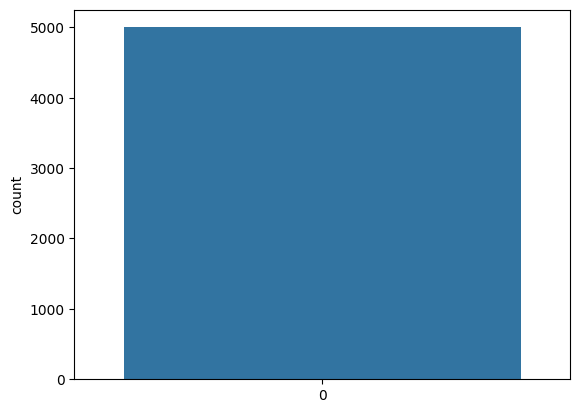

In [37]:
import seaborn as sns

sns.countplot(val_set_class_count)

In [38]:
train_dataset = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

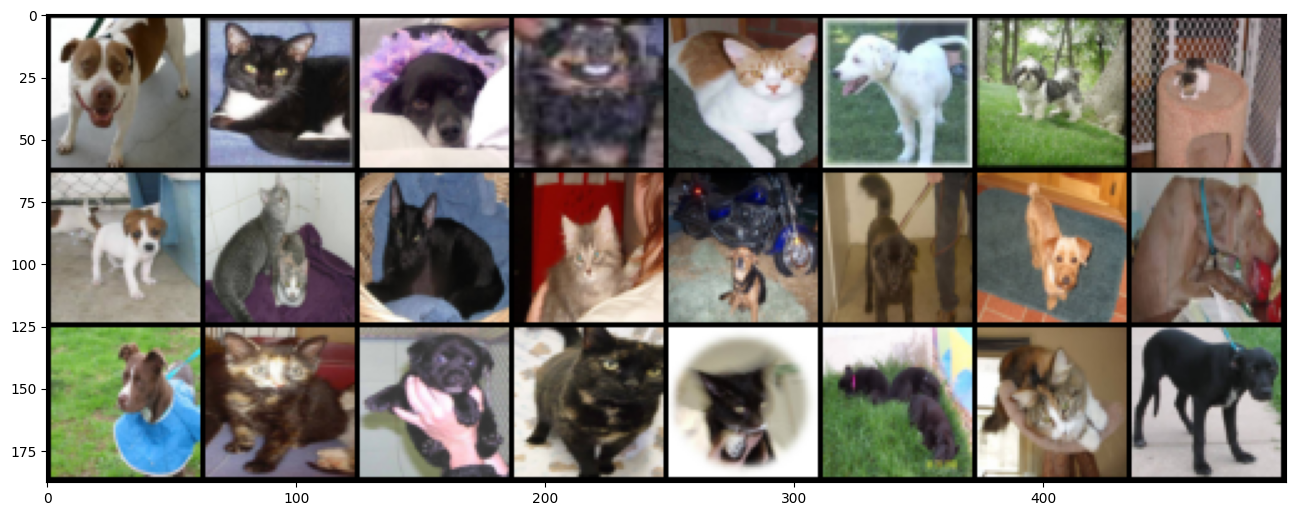

In [39]:
dataiter = iter(train_dataset)
samples, labels = next(dataiter)
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()


plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [40]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            ) 
            
        self.conv2 =   nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 
        self.conv3 =   nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 

        self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*5*5,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU()
        )
            
        self.fc2 = nn.Sequential(
        nn.Linear(128,2),
        )
                
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1) 

In [41]:
model = CNN()
model.cuda()
summary(model,(3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 256]         409,856
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

In [42]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 10

In [43]:
type(train_dataset)

torch.utils.data.dataloader.DataLoader

In [44]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Set our unit for tqdm and number of iterations i.e. len(train_dataset) no need for len as train_dataset is an iteratable
    # tepoch becomes 
    with tqdm(train_dataset, unit="batch") as tepoch:
        # our progress bar labels
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for data,label in tepoch:
            data,label = data.to(device), label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimiser.step() 

            train_running_loss += loss.item() * data.size(0)

            _, pred = torch.max(output.data, 1)

            # Keep track of how many images have been foward propagated
            total += label.size(0)
            # Keep track of how many were predicted to be correct
            correct += (pred == label).sum().item()

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Get our validation accuracy and loss scores
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # We don't need gradients for validation, so wrap in  no_grad to save memory
        with torch.no_grad():
            for val_data, val_label in val_dataset:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                # Calacuate the running loss by multiplying loss value by batch size
                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)    
                total += val_label.size(0)
                correct += (pred == val_label).sum().item()

            val_accuracy.append(correct/total)
            # Calcuate loss per epoch by dividing runing loss by number of items in validation set
            val_loss.append(val_running_loss/len(val_dataset))

            #print(val_running_loss)
            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')

<ipython-input-44-ed1d14d94d43>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit="batch") as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy = 0.6159
Epoch 1 Training Loss = 20.79075033416748
Epoch 1 Validation Accuracy = 0.6858
Epoch 1 Validation Loss = 19.153702344104744


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.70845
Epoch 2 Training Loss = 18.71683140258789
Epoch 2 Validation Accuracy = 0.7278
Epoch 2 Validation Loss = 18.021475782819614


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.74665
Epoch 3 Training Loss = 17.64999334411621
Epoch 3 Validation Accuracy = 0.7518
Epoch 3 Validation Loss = 17.273053879950456


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.76755
Epoch 4 Training Loss = 16.98288122253418
Epoch 4 Validation Accuracy = 0.7758
Epoch 4 Validation Loss = 16.656291749067368


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.79115
Epoch 5 Training Loss = 16.377444972229004
Epoch 5 Validation Accuracy = 0.7622
Epoch 5 Validation Loss = 17.039935266895657


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.7997
Epoch 6 Training Loss = 16.08263077545166
Epoch 6 Validation Accuracy = 0.7776
Epoch 6 Validation Loss = 16.644625197550294


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.8162
Epoch 7 Training Loss = 15.626138925170899
Epoch 7 Validation Accuracy = 0.7896
Epoch 7 Validation Loss = 16.276505992670728


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.82365
Epoch 8 Training Loss = 15.379908268737793
Epoch 8 Validation Accuracy = 0.7956
Epoch 8 Validation Loss = 16.12939748642551


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.8365
Epoch 9 Training Loss = 15.094792077636718
Epoch 9 Validation Accuracy = 0.7924
Epoch 9 Validation Loss = 16.156687820033664


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.8455
Epoch 10 Training Loss = 14.798523959350586
Epoch 10 Validation Accuracy = 0.8014
Epoch 10 Validation Loss = 15.956151564409778


In [45]:
train_loss

[20.79075033416748,
 18.71683140258789,
 17.64999334411621,
 16.98288122253418,
 16.377444972229004,
 16.08263077545166,
 15.626138925170899,
 15.379908268737793,
 15.094792077636718,
 14.798523959350586]

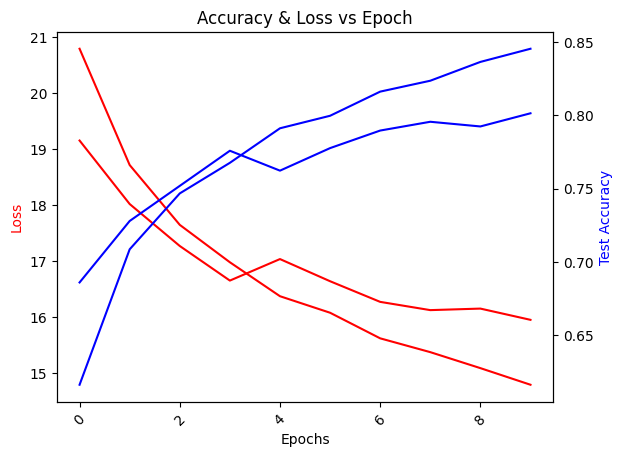

In [47]:
epoch_log = [*range(epochs)]


fig, ax1 = plt.subplots()


plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)


ax2 = ax1.twinx()


ax1.plot(epoch_log, train_loss, 'r-')
ax2.plot(epoch_log, train_accuracy, 'b-')


ax1.plot(epoch_log, val_loss, 'r-')
ax2.plot(epoch_log, val_accuracy, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [48]:
PATH = './cats_vs_dogs_10_epochs.pth'
torch.save(model.state_dict(), PATH)

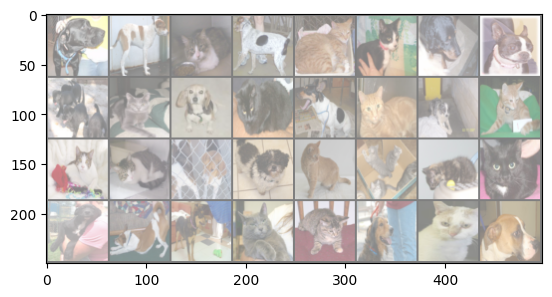

GroundTruth:  11010011101010100011000011100101


In [49]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(val_dataset)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',''.join('%1s' % labels[j].numpy() for j in range(32)))

In [50]:
model = CNN()
model.to(device)

model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

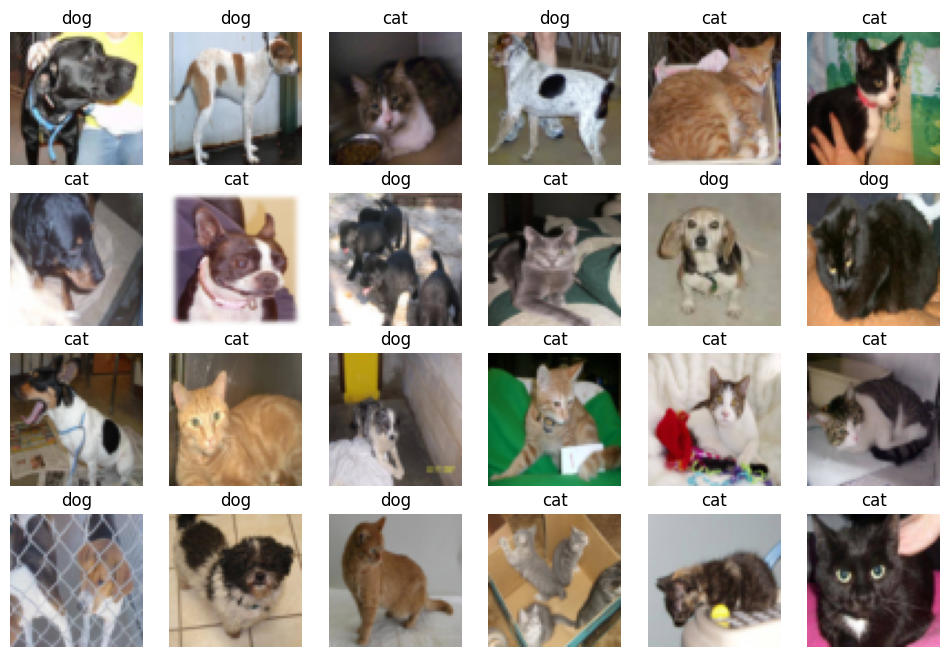

In [51]:
dataiter = iter(val_dataset)
samples, _  = next(dataiter)

samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))